In [63]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [245]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import re
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [131]:
df = pd.read_csv('https://media.githubusercontent.com/media/juliandariomirandacalle/NLP_Notebooks/master/01-Introduction_NLP/Customer_Reviews.csv')
df.head(3)

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [14]:
df.shape

(10000, 9)

In [11]:
#df.to_csv("Amazon Reviews sentiment analysis.csv")

In [17]:
df.isnull().sum()

ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

## Data Visualization

Text(0.5, 1.0, 'Count of Null Values')

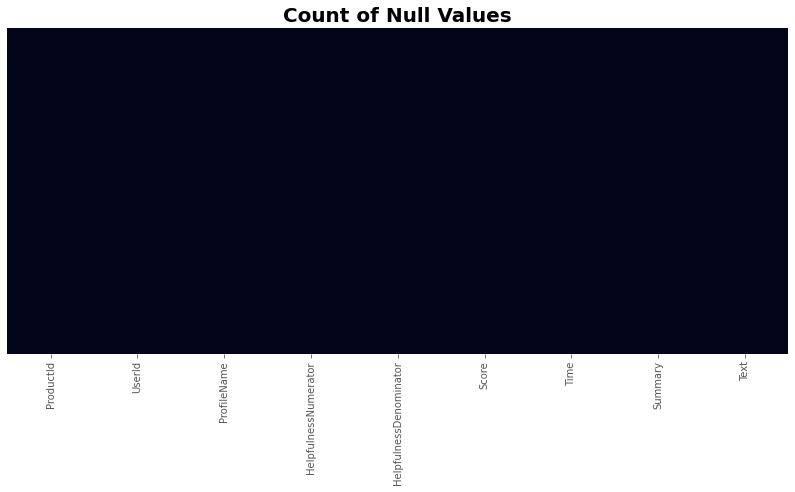

In [145]:
# Finding NA values visually
sns.heatmap(df.isnull(), yticklabels= False, cbar=False)
plt.title('Count of Null Values', fontsize=20, fontweight='bold')

[5, 1, 4, 2, 3]
[6183, 932, 1433, 590, 862]


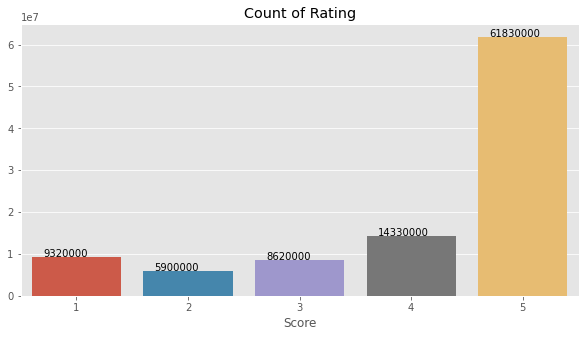

In [60]:
feature_dst = list(df['Score'].unique())
count_dst = []
for name in feature_dst:
    name = df.loc[df['Score'] == name].count()[0]
    count_dst.append(name)
print(feature_dst)
print(count_dst)

plt.figure(figsize=(10,5))
ax2 = sns.barplot(x='Score',y= df.Score.count(), data=df, estimator = np.sum, ci = None)
ax2.set_title('Count of Rating')
for p in ax2.patches:
        ax2.annotate('{:1.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
        

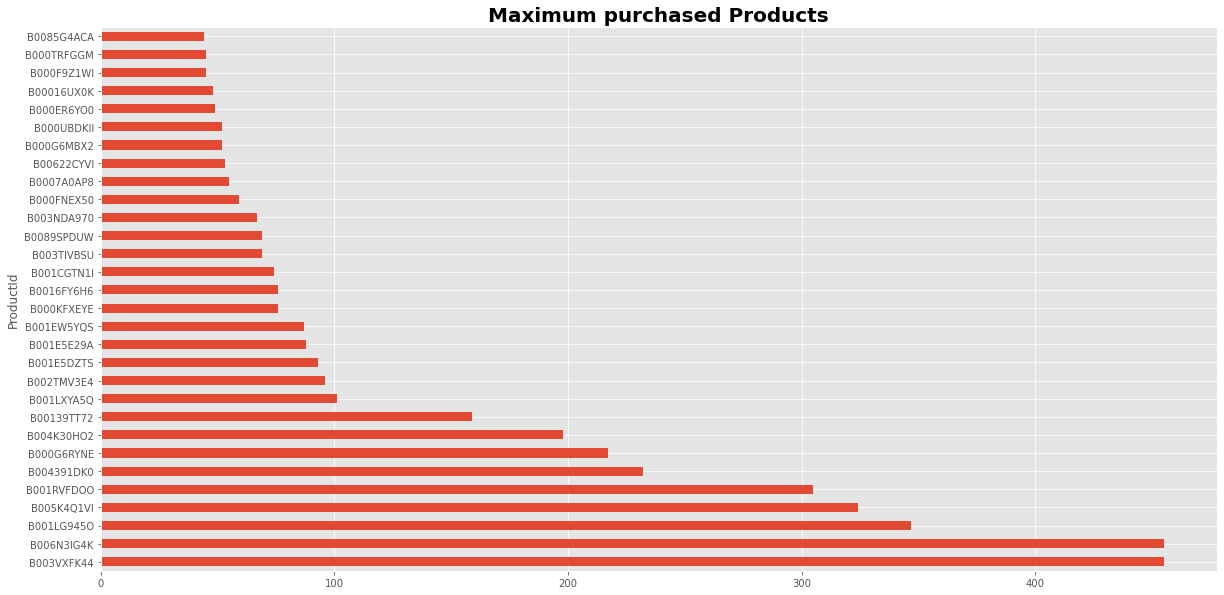

In [147]:
plt.figure(figsize=(20,10))
prd = df.groupby('ProductId').size()

prd.nlargest(30).plot(kind='barh')
plt.title('Maximum purchased Products', fontsize=20, fontweight='bold')
plt.show()

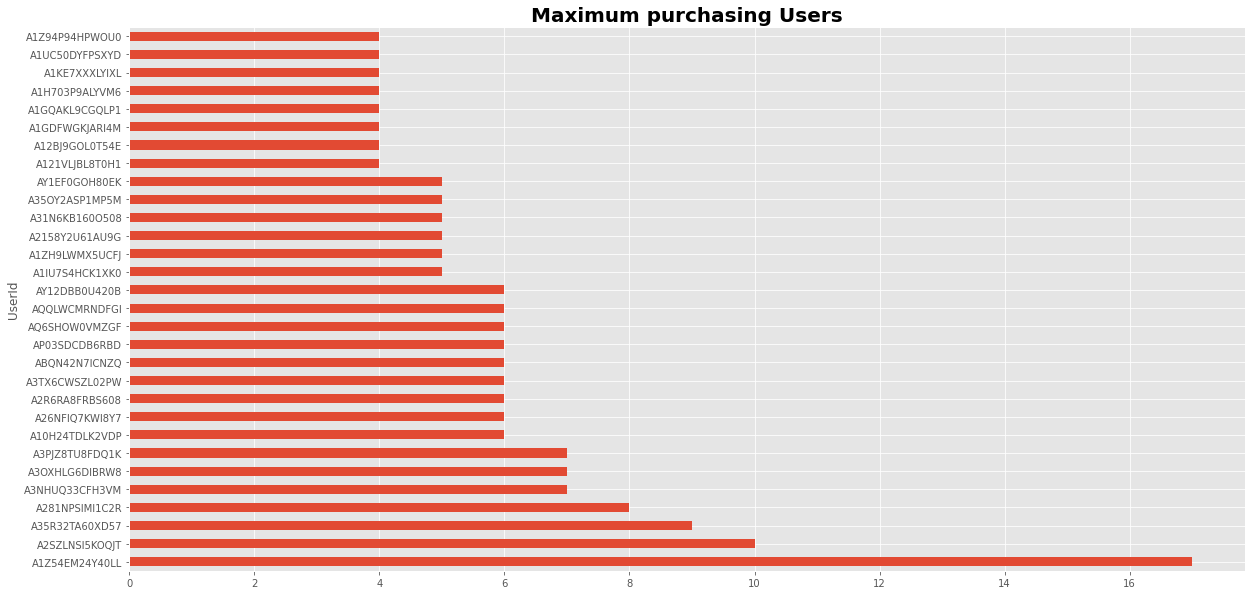

In [152]:
plt.figure(figsize=(20,10))
usd = df.groupby('UserId').size()
plt.title('Maximum purchasing Users', fontsize=20, fontweight='bold')
user = usd.nlargest(30).plot(kind='barh')
plt.show()

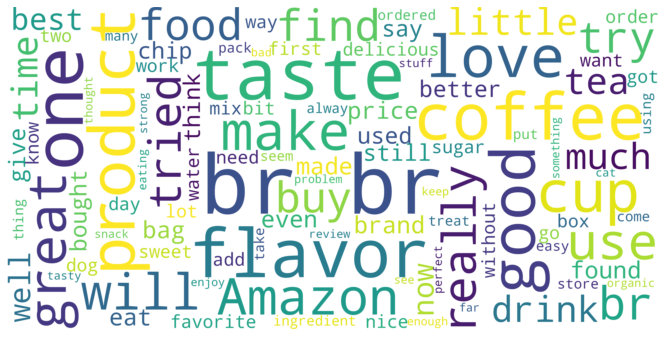

In [65]:
word_cloud_text = ''.join(amazon_reviews['Text'])

wordcloud = WordCloud(max_font_size=100, # Maximum font size for the largest word
                      max_words=100, # The maximum number of words
                      background_color="white", # Background color for the word cloud image
                      scale = 10, # Scaling between computation and drawing
                      width=800, # Width of the canvas
                      height=400 # Height of the canvas
                     ).generate(word_cloud_text)

plt.figure()
plt.imshow(wordcloud, 
           interpolation="bilinear") # to make the displayed image appear more smoothly
plt.axis("off")
plt.show()

In [124]:
df['Text'][21]

'I bought these for my husband who is currently overseas. He loves these, and apparently his staff likes them also.<br />There are generous amounts of Twizzlers in each 16-ounce bag, and this was well worth the price. <a href="http://www.amazon.com/gp/product/B001GVISJM">Twizzlers, Strawberry, 16-Ounce Bags (Pack of 6)</a>'

In [141]:
def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result
df['Text']=df['Text'].apply(lambda cw : remove_tags(cw))

df['Text'][21]

'I bought these for my husband who is currently overseas. He loves these, and apparently his staff likes them also.There are generous amounts of Twizzlers in each 16-ounce bag, and this was well worth the price. Twizzlers, Strawberry, 16-Ounce Bags (Pack of 6)'

In [150]:
df['Text'][6]

"This saltwater taffy had great flavors and was very soft and chewy.  Each candy was individually wrapped well.  None of the candies were stuck together, which did happen in the expensive version, Fralinger's.  Would highly recommend this candy!  I served it at a beach-themed party and everyone loved it!"

In [151]:
df['Text'] = df['Text'].str.replace(r'[^A-Za-z0-9 ]+', ' ')
df['Text'][6]

'This saltwater taffy had great flavors and was very soft and chewy   Each candy was individually wrapped well   None of the candies were stuck together  which did happen in the expensive version  Fralinger s   Would highly recommend this candy   I served it at a beach themed party and everyone loved it '

In [311]:
df['Text'] = df['Text'].str.replace(r'[^A-Za-z0-9 ]+', ' ')

In [228]:
df['Score_binary'] = np.where(df.Score > 3,1,0)

## Removing neutral reviews 
df = df[df.Score != 3]

df['Score_binary'].value_counts()

1    7616
0    1522
Name: Score_binary, dtype: int64

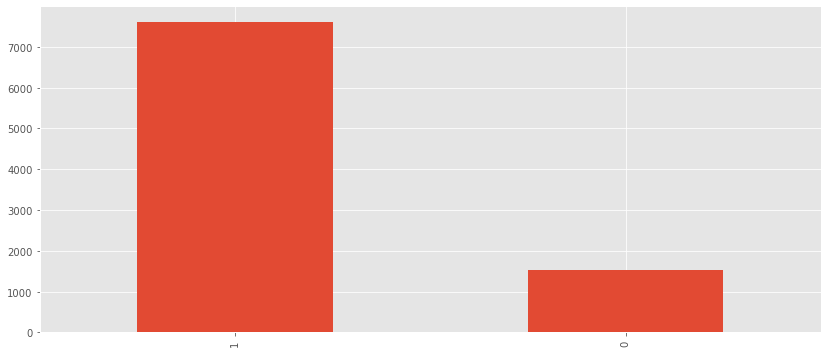

In [230]:
df.Score_binary.value_counts().plot.bar()
plt.show()

## TFIDF

In [312]:
tfidf_counts = TfidfVectorizer(tokenizer= word_tokenize, # type of tokenization
                               stop_words= stopwords.words('english'), # List of stopwords
                               ngram_range=(1,1)) # number of n-grams

tfidf_data = tfidf_counts.fit_transform(df['Text'])

In [313]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_data,
                                                    df['Score_binary'],
                                                    test_size = 0.2,
                                                    random_state = 0)

In [314]:
lr = LogisticRegression()

## Training the model 
lr.fit(X_train , y_train)

## Prediciting the results
y_test_pred_lr = lr.predict(X_test)

## Evaluating the model
print("F1 score: ", f1_score(y_test, y_test_pred_lr))


F1 score:  0.9353566009104705


## Bag Of Words

In [301]:
bow_counts = CountVectorizer(tokenizer= word_tokenize, # type of tokenization
                             stop_words= stopwords.words('english'), # List of stopwords
                             ngram_range=(1,2)) # number of n-grams

bow_data = bow_counts.fit_transform(df['Text'])

In [306]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(bow_data, # Features
                                                                    df['Score_binary'], # Target variable
                                                                    test_size = 0.2, # 20% test size
                                                                    random_state = 0) # random state for replication purposes

In [307]:
### Training the model 
lr_bow = LogisticRegression() # Logistic regression
lr_bow.fit(X_train_bow, y_train_bow) # Fitting a logistic regression model

## Predicting the output
test_pred_lr_bow = lr_bow.predict(X_test_bow) # Class prediction

## Calculate key performance metrics
print("F1 score: ", f1_score(y_test_bow, test_pred_lr_bow))

F1 score:  0.9520807061790668
